In [20]:
import json

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import torch
import torch.nn.functional as F


from collections import Counter

from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from src.word_to_embedding import WordToEmbedding

RANDOM_STATE = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
w2e = WordToEmbedding()

In [3]:
def generate_label_mapping(data: pd.DataFrame):
    label_to_id = {item: i for i, item in enumerate(set(data['произход']))}
    id_to_label = {index: label for label, index in label_to_id.items()}

    return label_to_id, id_to_label

In [4]:
class LoanwordsDataset(Dataset):
    def __init__(self, data: pd.DataFrame, label_to_id: dict[str, int], embeddeing_engine: WordToEmbedding):
        self.__data = data
        self.__len = self.__data.shape[0]
        
        self.__label_mapping = label_to_id
        self.__embeddeing_engine = embeddeing_engine


    def __len__(self):
        return self.__len

    def __getitem__(self, index) -> tuple[str, str]:
        entry = self.__data.iloc[index]

        word = entry['дума']
        origin = entry['произход']
        word_tensor = self.__embeddeing_engine.get_embedding(word)
        origin_tensor = self.__label_mapping[origin]

        word_tensor_shape = word_tensor.shape
        word_tensor = word_tensor.reshape((word_tensor_shape[0], 1, word_tensor_shape[1]))

        return word, word_tensor, origin, origin_tensor


In [16]:
class LoanwordClassifier(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.__hidden_size = hidden_size

        self.__i2h = nn.Linear(input_size + self.__hidden_size, self.__hidden_size).to(device)
        self.__h2h = nn.Linear(hidden_size, hidden_size).to(device)
        self.__h2h_2 = nn.Linear(hidden_size, hidden_size).to(device)
        self.__h2o = nn.Linear(hidden_size, output_size).to(device)
        self.__softmax = nn.LogSoftmax(dim=1).to(device)

    def forward(self, input_tensor, hidden):
        combined = torch.cat((input_tensor.to(device), hidden.to(device)), 1).to(device)
        hidden = F.tanh(self.__i2h(combined).to(device) + self.__h2h(hidden.to(device)).to(device)).to(device)
        hidden = F.tanh(hidden + self.__h2h_2(hidden.to(device)).to(device)).to(device)
        output = self.__h2o(hidden).to(device)
        output = self.__softmax(output).to(device)

        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.__hidden_size)

In [6]:
def category_from_output(output, id_to_label):
    top_n, top_i = output.topk(1)

    category_i = top_i[0].item()
    return id_to_label[category_i], category_i

In [7]:
def train_epoch(model: LoanwordClassifier, train_dataloader, loss_fn,  id_to_label, learning_rate=0.005):
    sum_loss = 0
    for word, word_tensor, label, label_tensor in tqdm(train_dataloader):
        word_tensor = word_tensor[0]
        hidden = model.init_hidden()
        model.zero_grad()

        for syllable_embedding in word_tensor:
            output, hidden = model(syllable_embedding, hidden)
        
        loss = loss_fn(output.to(device), label_tensor.to(device))
        loss.backward()

        for p in model.parameters():
            p.data.add_(p.grad.data, alpha=-learning_rate)
        
        sum_loss += loss.item()

    return sum_loss / len(train_dataloader)

In [8]:
# Train & Test loop
def train_loop(model: LoanwordClassifier, train_dataloader, epochs, loss_fn, id_to_label, learning_rate=0.005):
    for epoch in range(epochs):
        
        epoch_loss = train_epoch(model, train_dataloader, loss_fn, id_to_label, learning_rate)
        print(f"Epoch: {epoch}, loss: {epoch_loss:>7f}")

In [9]:
def test_loop(model: LoanwordClassifier, test_dataloader, id_to_label):
    predicted_ids = []
    actual_ids = []
    for word, word_tensor, label, label_tensor in tqdm(test_dataloader):
        word_tensor = word_tensor[0]

        hidden = model.init_hidden()

        for syllable_embedding in word_tensor:
            output, hidden = model(syllable_embedding, hidden)

        predicted_label, predicted_label_id = category_from_output(output, id_to_label)
        # print(predicted_label, predicted_label_id)
        predicted_ids.append(predicted_label_id)
        actual_ids.append(label_tensor)
    
    return predicted_ids, actual_ids

In [10]:
def get_distribution(train_data, label_to_id):
    counts = train_data['произход'].value_counts(normalize=True)
    weights = sorted(zip(counts.keys(), counts), key=lambda x: label_to_id[x[0]])
    weights = list(map(lambda x: x[1], weights))
    return torch.Tensor(weights)

In [17]:
path = '/mnt/d/Projects/masters-thesis/data/loanwords_3.csv'
data = pd.read_csv(path)
label_to_id, id_to_label = generate_label_mapping(data)

# Running the model with normal labels 
train_data, test_data = train_test_split(data, random_state=RANDOM_STATE)


train_dataset = LoanwordsDataset(train_data, label_to_id, embeddeing_engine=w2e)
train_dataloader = DataLoader(train_dataset)

test_dataset = LoanwordsDataset(test_data, label_to_id, embeddeing_engine=w2e)
test_dataloader = DataLoader(test_dataset)

model = LoanwordClassifier(input_size=512, hidden_size=1024, output_size=len(label_to_id))
distribution = get_distribution(train_data, label_to_id).to(device)
loss_fn = nn.NLLLoss(distribution)


In [18]:
train_loop(model, train_dataloader, epochs=15, loss_fn=loss_fn, id_to_label=id_to_label)

100%|██████████| 14327/14327 [01:12<00:00, 198.25it/s]


Epoch: 0, loss: 0.932856


100%|██████████| 14327/14327 [01:19<00:00, 179.25it/s]


Epoch: 1, loss: 0.795178


100%|██████████| 14327/14327 [01:12<00:00, 197.36it/s]


Epoch: 2, loss: 0.723851


100%|██████████| 14327/14327 [01:10<00:00, 202.91it/s]


Epoch: 3, loss: 0.678751


100%|██████████| 14327/14327 [01:11<00:00, 201.02it/s]


Epoch: 4, loss: 0.643358


100%|██████████| 14327/14327 [01:13<00:00, 195.75it/s]


Epoch: 5, loss: 0.619124


100%|██████████| 14327/14327 [01:12<00:00, 197.76it/s]


Epoch: 6, loss: 0.596750


100%|██████████| 14327/14327 [01:10<00:00, 202.88it/s]


Epoch: 7, loss: 0.563233


100%|██████████| 14327/14327 [01:12<00:00, 196.43it/s]


Epoch: 8, loss: 0.552799


100%|██████████| 14327/14327 [01:09<00:00, 205.62it/s]


Epoch: 9, loss: 0.532496


100%|██████████| 14327/14327 [01:08<00:00, 208.60it/s]


Epoch: 10, loss: 0.539615


100%|██████████| 14327/14327 [01:12<00:00, 198.43it/s]


Epoch: 11, loss: 0.524152


100%|██████████| 14327/14327 [01:11<00:00, 200.04it/s]


Epoch: 12, loss: 0.533790


100%|██████████| 14327/14327 [01:11<00:00, 199.52it/s]


Epoch: 13, loss: 0.527026


100%|██████████| 14327/14327 [01:11<00:00, 200.16it/s]

Epoch: 14, loss: 0.509084


In [ ]:
from datetime import datetime
today_date = datetime.today().strftime('%Y-%m-%d')
torch.save(model.state_dict(), f'models/classifier-3-{today_date}-1024hidden-10epochs.pth')

In [ ]:
from datetime import datetime
today_date = datetime.today().strftime('%Y-%m-%d')

id_to_label_json = json.dumps(id_to_label)
with open(f'models/id-to-label-3-{today_date}-1024hidden-10epochs.json', 'w+') as fp:
    fp.write(id_to_label_json)


label_to_id_json = json.dumps(label_to_id)
with open(f'models/label-to-id-3-{today_date}-1024hidden-10epochs.json', 'w+') as fp:
    fp.write(label_to_id_json)

In [22]:
p, a = test_loop(model, test_dataloader, id_to_label)
a = [t.item() for t in a]

100%|██████████| 4776/4776 [00:18<00:00, 262.27it/s]


In [23]:
print(f1_score(a, p, average='weighted'))
print(precision_score(a, p, average='weighted'))
print(recall_score(a, p, average='weighted'))

0.7165043039987585
0.7030179613679097
0.7361809045226131


/home/lyubolp/detecting-loanwords/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lyubolp/detecting-loanwords/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def accuracy(results):
    correct = sum(1 for p, a in results if p == a)
    return correct / len(results) * 100

def precision(results, amount_of_classes):
    return sum(precision_c(results, c) for c in range(amount_of_classes)) / (amount_of_classes + 1)

def precision_c(results, c):
    correct = sum(1 for p, a in results if p == a and p == c)
    total = sum(1 for p, _ in results if p == c)

    if total == 0:
        if correct == 0:
            return 1
        else:
            return 0
    return correct / total

def recall(results, amount_of_classes):
    return sum(recall_c(results, c) for c in range(amount_of_classes)) / (amount_of_classes + 1)

def recall_c(results, c):
    correct = sum(1 for p, a in results if p == a and p == c)
    total = sum(1 for _, a in results if a == c)

    if total == 0:
        if correct == 0:
            return 1
        else:
            return 0
    
    return correct / total

In [ ]:
results = list(zip(p, a))
amount_of_classes = len(label_to_id)

print(f'accuracy: {accuracy(results):.2f}%')
print(f'precision: {precision(results, amount_of_classes) * 100:.2f}%')
print(f'recall: {recall(results, amount_of_classes) * 100:.2f}%')
print(f'f1: {f1_score(a, p, average="weighted"):.3f}')

/tmp/ipykernel_15772/575425773.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(label_to_id.keys()), rotation=90)
/tmp/ipykernel_15772/575425773.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(label_to_id.keys()))


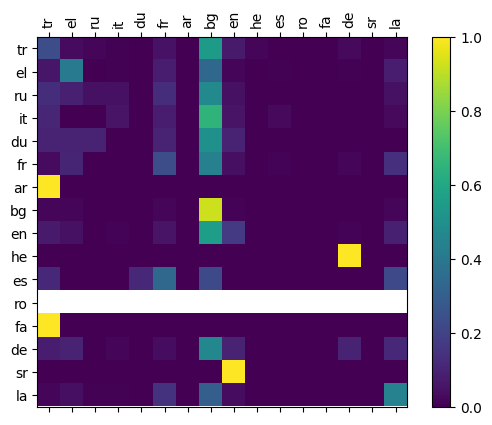

In [39]:
confusion = torch.zeros(len(label_to_id), len(label_to_id))
for predicted, actual in results:
    confusion[actual][predicted] += 1

for i in range(len(label_to_id)):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + list(label_to_id.keys()), rotation=90)
ax.set_yticklabels([''] + list(label_to_id.keys()))

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()